# Feature Engineering & Target Definition

## Context & Previous Work
- In the previous version of the project, we used returns over a certain period of time to predict trends. This was clearly unsuccessful
- Then, we identified the Golden Cross rule to be the best way to classify financial trend over several different methods (in the target_testing notebook)
- We have with this target stable regimes with few transitions

## New Target: Transition Prediction

### Motivation
- We know that the Golden Cross rule is functionning to predict financial trend, but use it as a target to predict with ML models is useless, one could just compute it.
- What we will implement here is a "transition incoming" target. More explanations below

### Target Definition
- Target: "transition_incoming". in other words, the target will no longer be Bullish/Non-Bullish, but rather "a transition is coming/Nothing is coming" 
- Label = 1 during the **30-day window preceding** a transition
- Label = 0 otherwise
- This creates a prediction horizon: we want to detect transitions up to 30 days in advance

### Decision Rule (Rolling days confirmation)
- Identified issue: Classifying a transition with only one label 1 30 days before the transition happens is subject to false positive (which is very dangerous in finance)
- So, we implemented a rule: A transition is coming if during 10 days, at least 7 labels were equal to 1. It allows the prediciton to be more accurate and less strict than 10 out of 10 1 labels.
- Trade-off: With the 10-day rolling window, we effectively predict transitions with **20-30 days of advance notice** (depending on when the 7/10 threshold is met)

## Class Imbalance
- With 25 transitions over ~6100 trading days, and a 30-day labeling window, we expect approximately **12% positive labels**
- This class imbalance reflects market reality: regime transitions are rare events
- We will address this through:
  * Appropriate evaluation metrics (Precision, Recall, F1, AUC-PR)
  * Class weighting in models if needed
  * Focus on Precision over Recall (false positives are costly)

### Excluded Features (data leakage)

Since the financial regime is computed according to the Golden Cross rule, any features including directly or indirectly the usage of moving averages (MA, EMA, MACD...) are excluded to prevent data leakage

### Included Features
- Actual features : vol, returns, cumulative returns, RSI
- New features : ATR, Volume ROC, Stochastic oscillator

## Implementation Plan
1. Implement the new labeling function with 30-day window
2. Add new technical indicators (ATR, Volume ROC, Stochastic)
3. Verify no feature correlation/redundancy
4. Train baseline models with proper temporal split
5. Evaluate with Precision-focused metrics

In [2]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.data_loader import load_data


spy = load_data()
spy.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2000-01-03 00:00:00-05:00,93.388790,93.388790,90.632797,91.617081,8164300,0.0,0.0,0.0
1,2000-01-04 00:00:00-05:00,90.416213,90.750869,87.965349,88.034248,8089800,0.0,0.0,0.0
2,2000-01-05 00:00:00-05:00,88.152378,89.156347,86.459412,88.191750,12177900,0.0,0.0,0.0
3,2000-01-06 00:00:00-05:00,87.955515,89.136655,86.774376,86.774376,6227200,0.0,0.0,0.0
4,2000-01-07 00:00:00-05:00,88.388563,91.813866,88.231078,91.813866,8066500,0.0,0.0,0.0


In [3]:
from src.features import add_all_features, add_target_ma_cross

In [4]:
df = spy.copy()
df = add_all_features(df)
df = add_target_ma_cross(df, short_window=50, long_window=200)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Return,Log Return,Volatility,Cumulated_Return_5d,RSI14,Stoch_K,Volume_ROC,ATR,Golden_Cross
0,2000-01-03 00:00:00-05:00,93.388790,93.388790,90.632797,91.617081,8164300,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non-Bullish
1,2000-01-04 00:00:00-05:00,90.416213,90.750869,87.965349,88.034248,8089800,0.0,0.0,0.0,-0.039107,-0.039892,NaN,NaN,NaN,NaN,NaN,NaN,Non-Bullish
2,2000-01-05 00:00:00-05:00,88.152378,89.156347,86.459412,88.191750,12177900,0.0,0.0,0.0,0.001789,0.001787,NaN,NaN,NaN,NaN,NaN,NaN,Non-Bullish
3,2000-01-06 00:00:00-05:00,87.955515,89.136655,86.774376,86.774376,6227200,0.0,0.0,0.0,-0.016071,-0.016202,NaN,NaN,NaN,NaN,NaN,NaN,Non-Bullish
4,2000-01-07 00:00:00-05:00,88.388563,91.813866,88.231078,91.813866,8066500,0.0,0.0,0.0,0.058076,0.056452,NaN,NaN,NaN,NaN,NaN,NaN,Non-Bullish


In [5]:
def add_target(df: pd.DataFrame, period=30):
    df1 = df.copy()
    df1['Golden_Cross'] = df1['Golden_Cross'].replace({'Non-Bullish': 0, 'Bullish': 1})
    

    df1['Transition'] = 0
    

    label = df1['Golden_Cross'].iloc[0]
    indices = []
    for i in range(1, len(df1)):
        if df1['Golden_Cross'].iloc[i] != label:
            label = df1['Golden_Cross'].iloc[i]
            indices.append(i)

    for i in indices:
        start = max(0, i - period)  
        df1.loc[start:i-1, 'Transition'] = 1  
    
    return df1, indices

df1 = add_target(df)[0]

print(f"Number of days with transition = 1: {df1['Transition'].sum()}")
print(f"Number of transitions: {len(add_target(df)[1])}") 
print(f"Proportion of transition: {df1['Transition'].mean():.2%}")
print('\n-----------------------------------------------------------------------\n')

Number of days with transition = 1: 713
Number of transitions: 25
Proportion of transition: 11.34%

-----------------------------------------------------------------------



C:\Users\alexa\AppData\Local\Temp\ipykernel_30096\1724402832.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Golden_Cross'] = df1['Golden_Cross'].replace({'Non-Bullish': 0, 'Bullish': 1})
C:\Users\alexa\AppData\Local\Temp\ipykernel_30096\1724402832.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Golden_Cross'] = df1['Golden_Cross'].replace({'Non-Bullish': 0, 'Bullish': 1})


In [6]:
df1.head(20)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Return,Log Return,Volatility,Cumulated_Return_5d,RSI14,Stoch_K,Volume_ROC,ATR,Golden_Cross,Transition
0,2000-01-03 00:00:00-05:00,93.388790,93.388790,90.632797,91.617081,8164300,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2000-01-04 00:00:00-05:00,90.416213,90.750869,87.965349,88.034248,8089800,0.0,0.0,0.0,-0.039107,-0.039892,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2000-01-05 00:00:00-05:00,88.152378,89.156347,86.459412,88.191750,12177900,0.0,0.0,0.0,0.001789,0.001787,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2000-01-06 00:00:00-05:00,87.955515,89.136655,86.774376,86.774376,6227200,0.0,0.0,0.0,-0.016071,-0.016202,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2000-01-07 00:00:00-05:00,88.388563,91.813866,88.231078,91.813866,8066500,0.0,0.0,0.0,0.058076,0.056452,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5,2000-01-10 00:00:00-05:00,92.128899,92.542298,91.361158,92.128899,5741700,0.0,0.0,0.0,0.003431,0.003425,NaN,0.005586,NaN,NaN,NaN,NaN,0,0
6,2000-01-11 00:00:00-05:00,91.853310,92.030481,90.396571,91.026512,7503700,0.0,0.0,0.0,-0.011966,-0.012038,NaN,0.033990,NaN,NaN,NaN,NaN,0,0
7,2000-01-12 00:00:00-05:00,91.085562,91.085562,90.002850,90.120964,6907700,0.0,0.0,0.0,-0.009948,-0.009998,NaN,0.021875,NaN,NaN,NaN,NaN,0,0
8,2000-01-13 00:00:00-05:00,91.006782,91.813894,90.258727,91.341438,5158300,0.0,0.0,0.0,0.013543,0.013452,NaN,0.052631,NaN,NaN,NaN,NaN,0,0
9,2000-01-14 00:00:00-05:00,92.306081,92.896651,91.951739,92.581680,7437300,0.0,0.0,0.0,0.013578,0.013487,NaN,0.008363,NaN,NaN,NaN,NaN,0,0


Missing Values
-------------------

Date                    0
Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
Dividends               0
Stock Splits            0
Capital Gains           0
Return                  1
Log Return              1
Volatility             20
Cumulated_Return_5d     5
RSI14                  14
Stoch_K                15
Volume_ROC             14
ATR                    13
Golden_Cross            0
Transition              0
dtype: int64


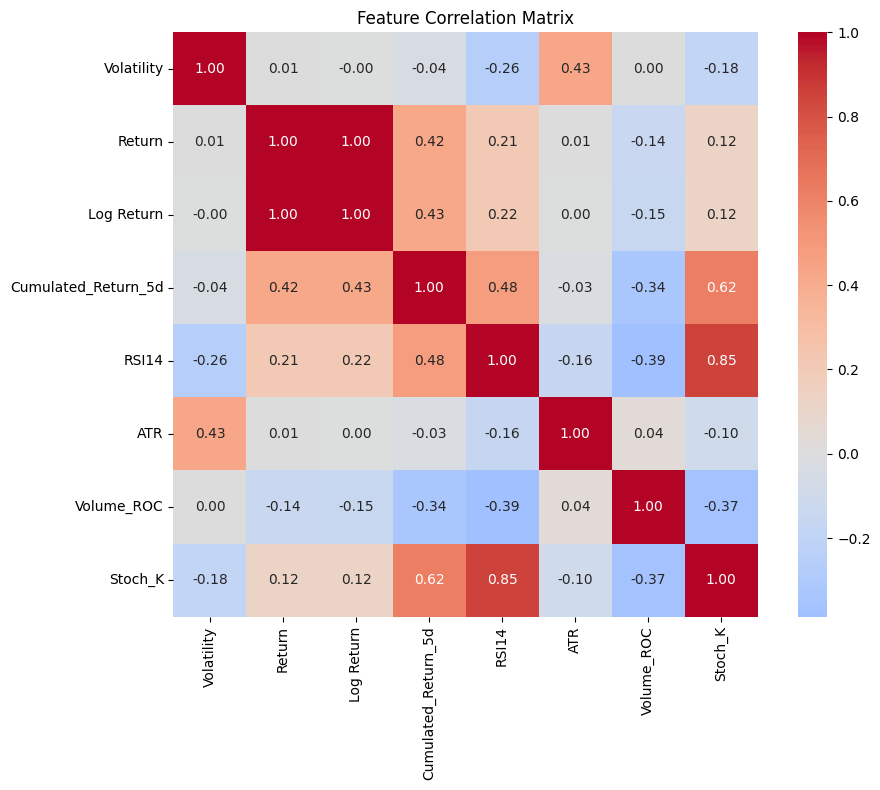

In [7]:
print('Missing Values\n-------------------\n')
print(df1.isnull().sum())


import seaborn as sns
import matplotlib.pyplot as plt

feature_cols = ['Volatility', 'Return', 'Log Return', 
                'Cumulated_Return_5d', 'RSI14', 'ATR', 'Volume_ROC', 'Stoch_K']
corr_matrix = df1[feature_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Feature Selection: Correlation-Based Removal

After computing the correlation matrix between all technical indicators, we identified two features to remove due to high redundancy:

### 1. Log Return (Dropped)
- **Correlation with Return**: 1.00 (perfect correlation, no value-added)
- **Reason**: Log returns and simple returns are mathematically equivalent for small price changes. Since our ML models don't benefit from the log transformation (unlike statistical models that assume normality), keeping both adds no information and creates perfect multicollinearity.
- **Decision**: Keep simple returns for better interpretability.

### 2. Stochastic Oscillator %K (Dropped)
- **Correlation with RSI14**: 0.85 (very high correlation)
- **Correlation with Cumulated_Return_5d**: 0.62 (moderate correlation)
- **Reason**: Both RSI and Stochastic are momentum oscillators, but they measure different aspects:
  - RSI captures the **strength/velocity** of price movements
  - Stochastic captures the **relative position** within the recent price range
  
  For predicting regime transitions, momentum strength (RSI) is more relevant than relative positioning. Additionally, RSI shows lower correlation with cumulative returns (0.48 vs 0.62), making it more orthogonal to our other features.

### Final Feature Set
After removal, our feature set contains:
- Volatility measures (vol_5, vol_20)
- Return (1-day)
- Cumulated_Return_5d
- RSI14 (momentum strength)
- ATR (volatility range)
- Volume_ROC (volume dynamics)

All remaining features show correlation < 0.65, ensuring minimal multicollinearity.

In [8]:
df_final = df1.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains', 'Stoch_K', 'Log Return'], axis=1)
df_final.head()

,Date,Return,Volatility,Cumulated_Return_5d,RSI14,Volume_ROC,ATR,Golden_Cross,Transition
0,2000-01-03 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2000-01-04 00:00:00-05:00,-0.039107,NaN,NaN,NaN,NaN,NaN,0,0
2,2000-01-05 00:00:00-05:00,0.001789,NaN,NaN,NaN,NaN,NaN,0,0
3,2000-01-06 00:00:00-05:00,-0.016071,NaN,NaN,NaN,NaN,NaN,0,0
4,2000-01-07 00:00:00-05:00,0.058076,NaN,NaN,NaN,NaN,NaN,0,0


In [10]:
df_final.to_csv('../data/df_with_features.csv')